<a href="https://colab.research.google.com/github/Akr-ds/Malaria-Classification-using-CNN/blob/main/Malaria_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing necessary Libraries**

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam



# **Loading the malaria dataset**

In [12]:
# Load dataset
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])



# **Defining the Split Function for Training,Testing,Validation**

In [13]:
# Split function
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    dataset_size = len(dataset)
    train_dataset = dataset.take(int(TRAIN_RATIO * dataset_size))
    val_dataset = dataset.skip(int(TRAIN_RATIO * dataset_size)).take(int(VAL_RATIO * dataset_size))
    test_dataset = dataset.skip(int((VAL_RATIO + TRAIN_RATIO) * dataset_size)).take(int(TEST_RATIO * dataset_size))
    return train_dataset, val_dataset, test_dataset


# **Testing the Function**

In [14]:
# Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Split datasets
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# **Defining the Resize & Rescale Function**

In [15]:
# Resize and rescale function
IM_SIZE = 224
def resize_rescale(image, label):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


# **Resizing and batching the dataset**

In [16]:
# Apply resizing and batching to all datasets
train_dataset = train_dataset.map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)

# **Building of Convolutional Neural Network Model **

In [17]:
# CNN model
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


# **Accessing Model Summary**

In [18]:
# Model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,257 (17.81 MB)

 Trainable params: 4,668,013 (17.81 MB)

 Non-trainable params: 244 (976.00 B)

# **Compiling The Model**

In [19]:
# Compile the model
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)

# **Training The Model**

In [20]:
# Train the model
history = model.fit(train_dataset,validation_data=val_dataset, epochs=20, verbose=1)  # you can change to 100 epochs later


Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.8221 - loss: 0.4057 - val_accuracy: 0.8519 - val_loss: 0.4744
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.9253 - loss: 0.2125 - val_accuracy: 0.9125 - val_loss: 0.2434
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9401 - loss: 0.1793 - val_accuracy: 0.9339 - val_loss: 0.1958
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 49s 64ms/step - accuracy: 0.9455 - loss: 0.1648 - val_accuracy: 0.7093 - val_loss: 0.4468
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.9496 - loss: 0.1512 - val_accuracy: 0.9477 - val_loss: 0.1630
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.9470 - loss: 0.1516 - val_accuracy: 0.9459 - val_loss: 0.1974
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.9556 - loss: 0.1284 - val_accuracy: 0.9368 - val_loss: 0.1938
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.9611 - loss: 0.1152 - 

# **Model Diagnostics**

# Plotting Training Loss & Validation Loss

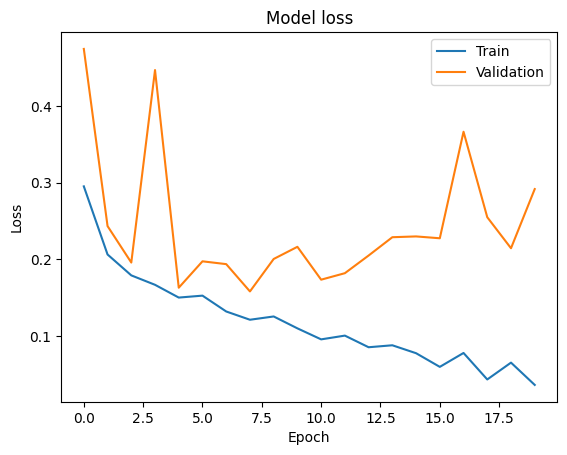

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting Training Accuracy & Validation Accuracy

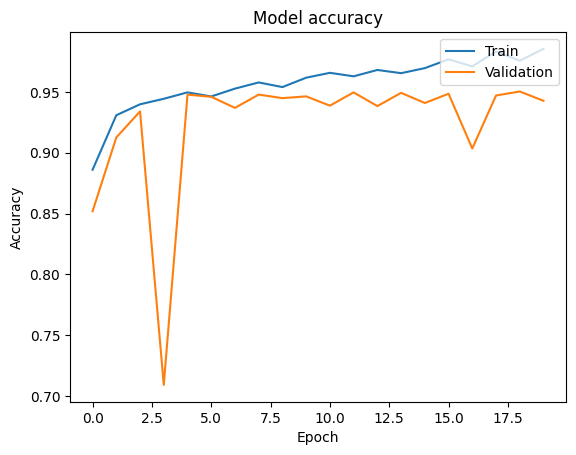

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluating The Model

In [23]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.9357 - loss: 0.3678


[0.36874327063560486, 0.9343012571334839]

# **Predicting The Test Dataset**

In [24]:
model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


np.float32(1.9398712e-13)

In [27]:
parasitic_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'Uninfected'

# Defining function for labelling predicted value

In [25]:
def parasitic_or_not(value):
    return "Parasitic" if round(value) == 1 else "Uninfected"


# **Plotting our result**

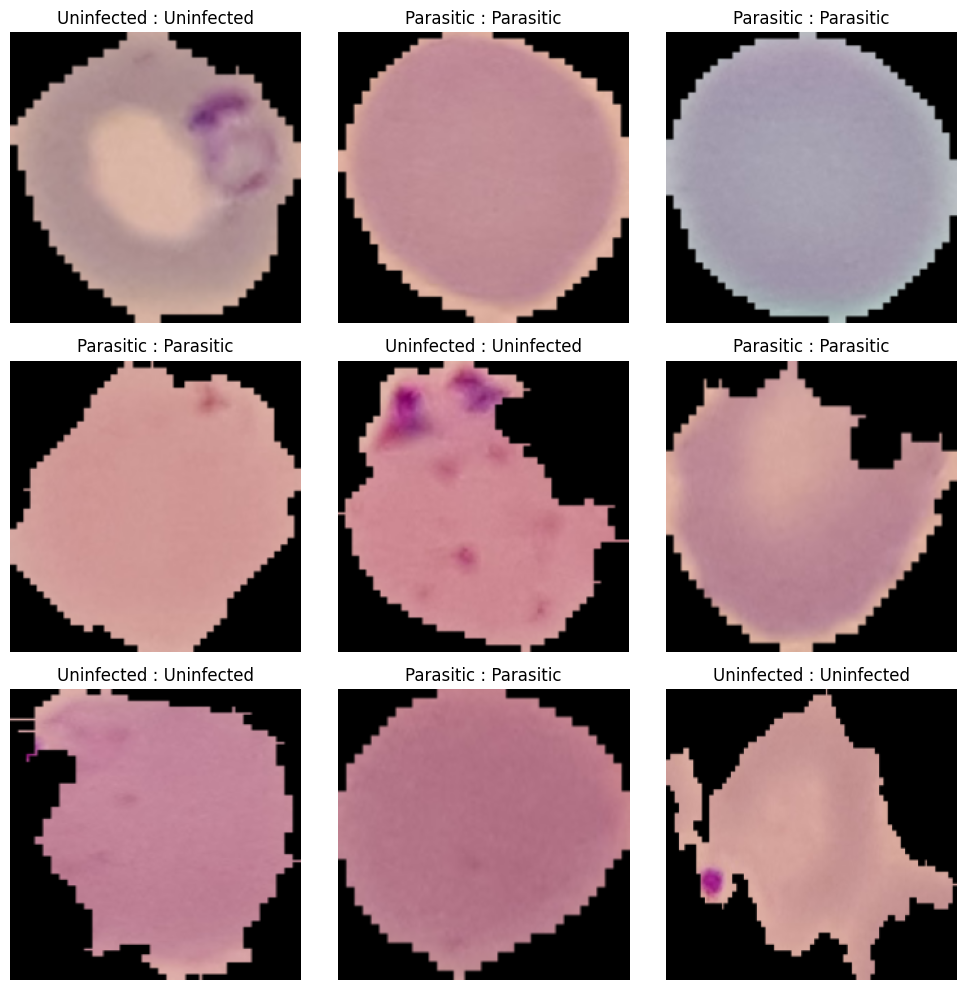

In [26]:
# Take 9 individual images from the dataset
plt.figure(figsize=(10, 10))

for i, (images, labels) in enumerate(test_dataset.unbatch().take(9)):
    # Expand dims to make shape (1, 224, 224, 3) for prediction
    img = tf.expand_dims(images, axis=0)
    pred = model.predict(img, verbose=0)[0][0]  # scalar prediction

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images)
    true_label = parasitic_or_not(labels.numpy())
    pred_label = parasitic_or_not(pred)
    plt.title(f"{true_label} : {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()